<h1 style="background-color:yellow;font-size:350%;text-align:center;border-radius: 50px 50px;padding: 15px">Female And Male Eyes Classification</h1>

<img src="https://user-images.githubusercontent.com/70811337/151632920-0cc0d3b2-957f-41f3-9be5-cbda6138c910.png" alt="Paris" style="display: block;
  margin-left: auto;
  margin-right: auto;">

<a id="1"></a> <br>
# 📥 Importing Libraries

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

<a id="2"></a> <br> 
# 🗃️ Load Dataset

In [ ]:
path = '../input/eyes-rtte'
path_img = list(glob.glob(path+'/**/*.jpg'))

In [ ]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,../input/eyes-rtte/maleeyes/1879.jpg,maleeyes
1,../input/eyes-rtte/femaleeyes/6884.jpg,femaleeyes
2,../input/eyes-rtte/maleeyes/4696.jpg,maleeyes
3,../input/eyes-rtte/femaleeyes/2013.jpg,femaleeyes
4,../input/eyes-rtte/femaleeyes/2993.jpg,femaleeyes


<a id="3"></a> <br>
# 🔥 EDA & Visualization

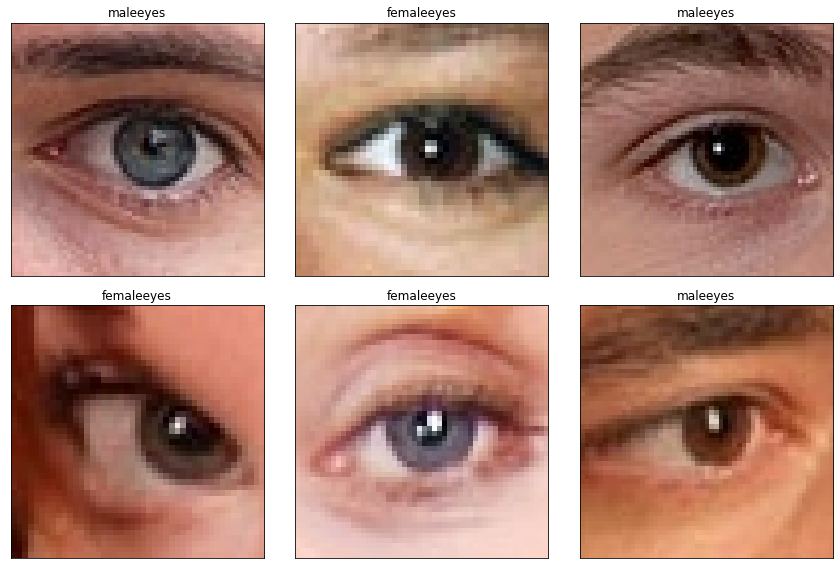

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

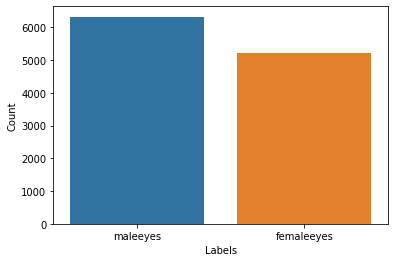

In [ ]:
counts = data.Labels.value_counts()
sns.barplot(x=counts.index, y=counts)
plt.xlabel('Labels')
plt.ylabel('Count');

<a id="4"></a> <br>
# ✂️ Train & Test Split

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=2)

<a id="5"></a> <br>
# 🦾 Function

In [ ]:
def func(pre,name_model):
    print('#####~Model => {} '.format(name_model))
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(100,100),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    
    pre_model = name_model(input_shape=(100,100, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(2, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]
    
    history = model.fit(train_gen,validation_data=valid_gen,epochs=100,callbacks=my_callbacks,verbose=0);
    print('\033[01m              Plotting Accuracy, val_accuracy, loss, val_loss \033[0m')
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
    plt.show()
    
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    print('\033[01m              Classification_report \033[0m')
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    print('\033[01m Display 6 pictures of the dataset with their labels \033[0m')
    # Display 6 pictures of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
    
    print('\033[01m              Results \033[0m')
    # Results
    results = model.evaluate(test_gen, verbose=0)
    print("    Test Loss:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(results[0]))
    print("Test Accuracy:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(results[1] * 100))
    
    return results

<a id="6"></a> <br>
# 📚 Training models

<a id="61"></a> <br>
<h2>✔️ VGG16</h2>

#####~Model => <function VGG16 at 0x7f8fc9e4c050> 
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.


2022-01-30 22:33:43.322930: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 22:33:43.419095: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 22:33:43.419874: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-30 22:33:43.420980: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

58900480/58889256 [==============================] - 0s 0us/step


2022-01-30 22:33:46.609693: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-30 22:33:48.177194: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


              Plotting Accuracy, val_accuracy, loss, val_loss 


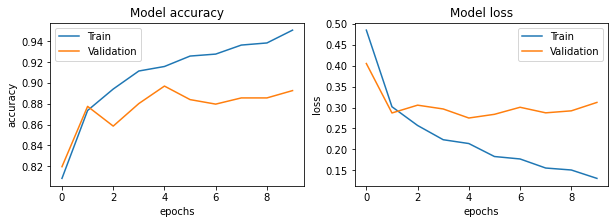

              Classification_report 
              precision    recall  f1-score   support

  femaleeyes       0.86      0.87      0.87      1011
    maleeyes       0.90      0.89      0.90      1294

    accuracy                           0.88      2305
   macro avg       0.88      0.88      0.88      2305
weighted avg       0.88      0.88      0.88      2305

 Display 6 pictures of the dataset with their labels 


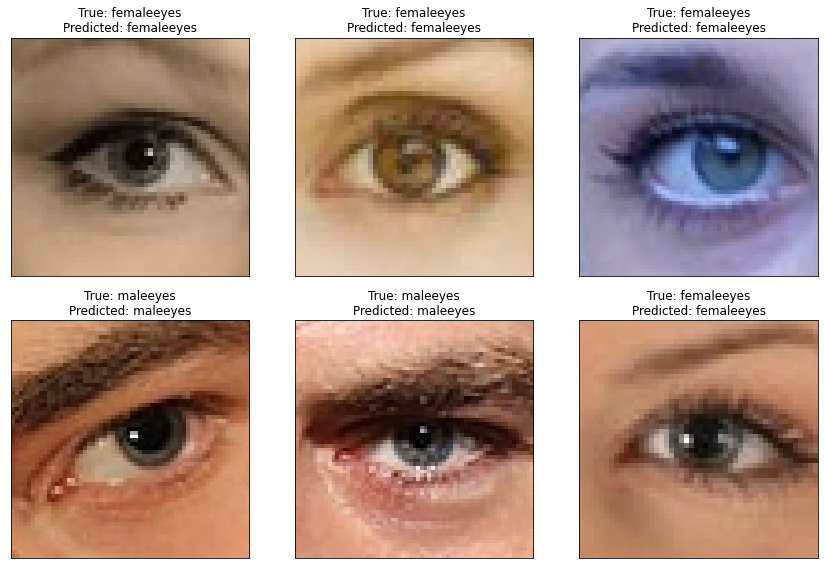

              Results 
    Test Loss:  0.35253  
Test Accuracy:  88.37%  


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
result_VGG16 = func(preprocess_input,VGG16)

<h2>✔️ VGG19</h2>

#####~Model => <function VGG19 at 0x7f8fc9e4c5f0> 
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.
80150528/80134624 [==============================] - 1s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


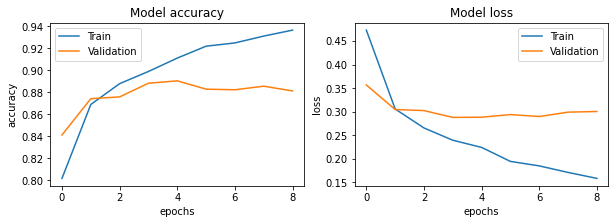

              Classification_report 
              precision    recall  f1-score   support

  femaleeyes       0.85      0.87      0.86      1011
    maleeyes       0.90      0.88      0.89      1294

    accuracy                           0.88      2305
   macro avg       0.87      0.88      0.87      2305
weighted avg       0.88      0.88      0.88      2305

 Display 6 pictures of the dataset with their labels 


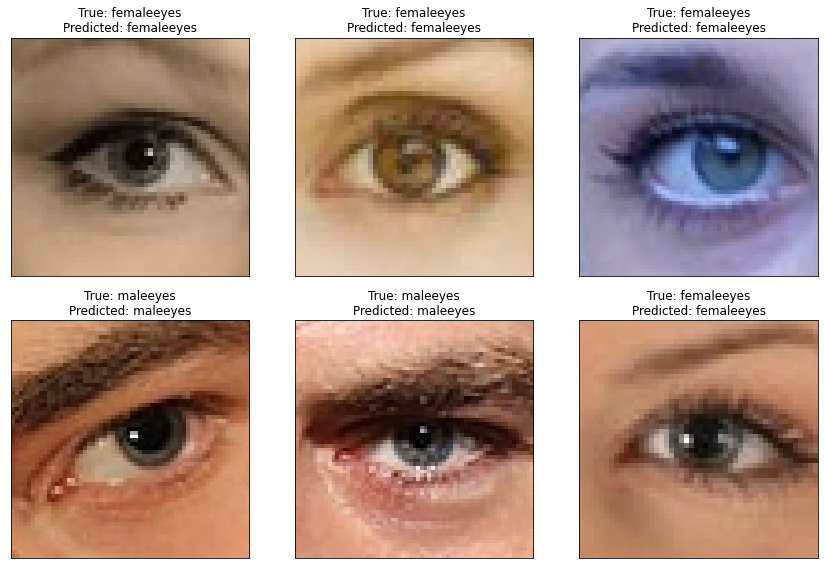

              Results 
    Test Loss:  0.34610  
Test Accuracy:  87.64%  


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
result_VGG19 = func(preprocess_input,VGG19)

<h2>✔️ ResNet50</h2>

#####~Model => <function ResNet50 at 0x7f8fc9e4b200> 
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.
94781440/94765736 [==============================] - 0s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


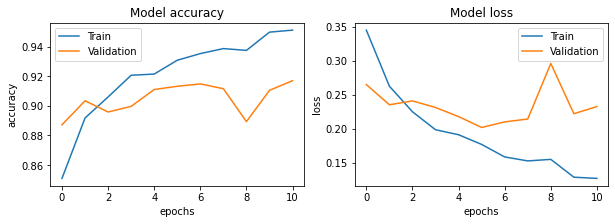

              Classification_report 
              precision    recall  f1-score   support

  femaleeyes       0.88      0.92      0.90      1011
    maleeyes       0.94      0.90      0.92      1294

    accuracy                           0.91      2305
   macro avg       0.91      0.91      0.91      2305
weighted avg       0.91      0.91      0.91      2305

 Display 6 pictures of the dataset with their labels 


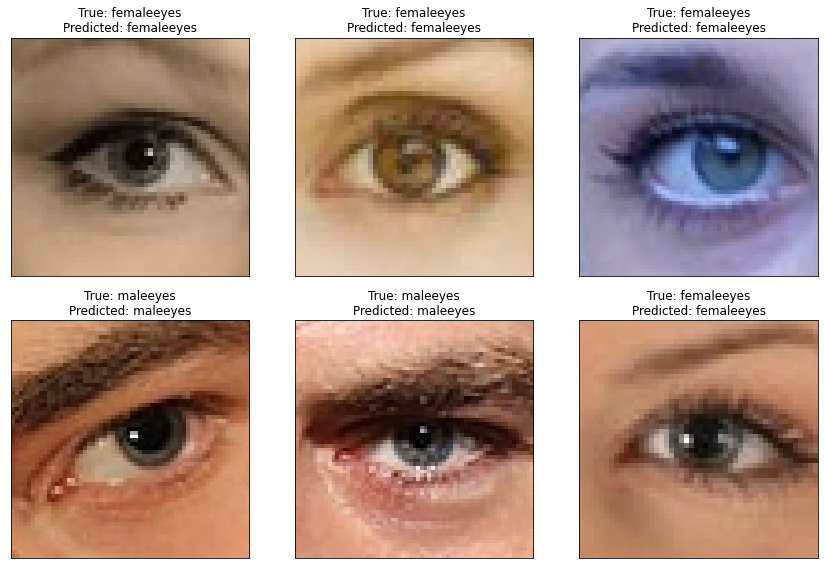

              Results 
    Test Loss:  0.22850  
Test Accuracy:  91.28%  


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
result_ResNet50 = func(preprocess_input,ResNet50)

<h2>✔️ ResNet101</h2>

#####~Model => <function ResNet101 at 0x7f8fc9e4b290> 
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.
171458560/171446536 [==============================] - 1s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


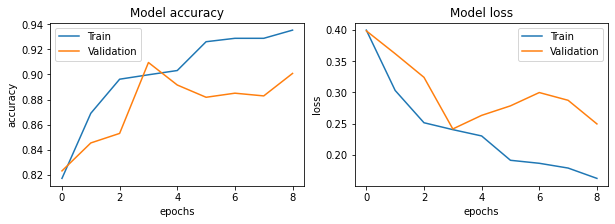

              Classification_report 
              precision    recall  f1-score   support

  femaleeyes       0.92      0.85      0.89      1011
    maleeyes       0.89      0.94      0.92      1294

    accuracy                           0.90      2305
   macro avg       0.91      0.90      0.90      2305
weighted avg       0.90      0.90      0.90      2305

 Display 6 pictures of the dataset with their labels 


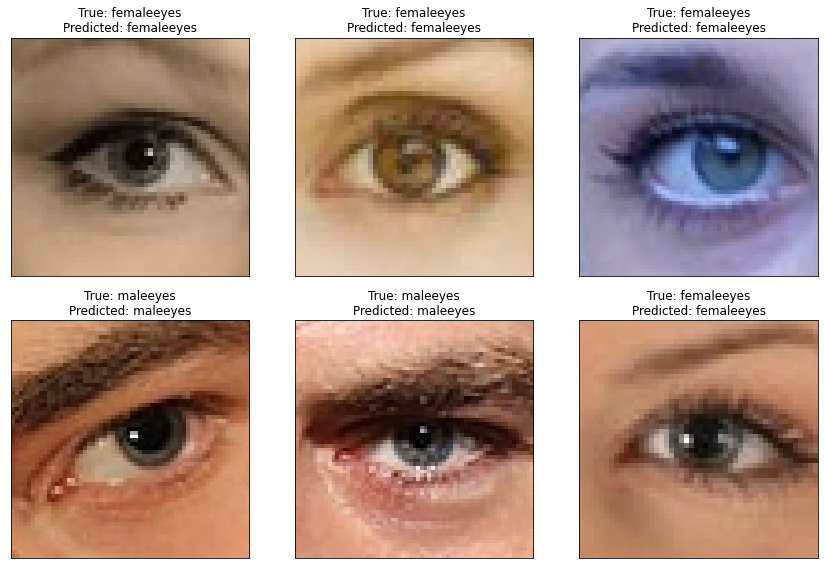

              Results 
    Test Loss:  0.24103  
Test Accuracy:  90.28%  


In [ ]:
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.applications.resnet import preprocess_input
result_ResNet101 = func(preprocess_input,ResNet101)

<h2>✔️ MobileNet</h2>

#####~Model => <function MobileNet at 0x7f8fc9e1bcb0> 
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.
17235968/17225924 [==============================] - 0s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


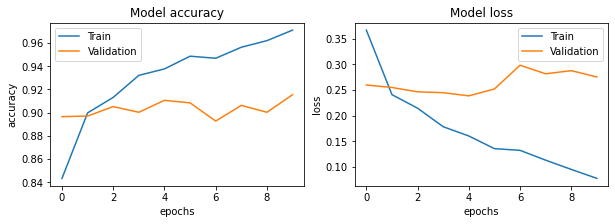

              Classification_report 
              precision    recall  f1-score   support

  femaleeyes       0.91      0.87      0.89      1011
    maleeyes       0.90      0.94      0.92      1294

    accuracy                           0.91      2305
   macro avg       0.91      0.90      0.90      2305
weighted avg       0.91      0.91      0.91      2305

 Display 6 pictures of the dataset with their labels 


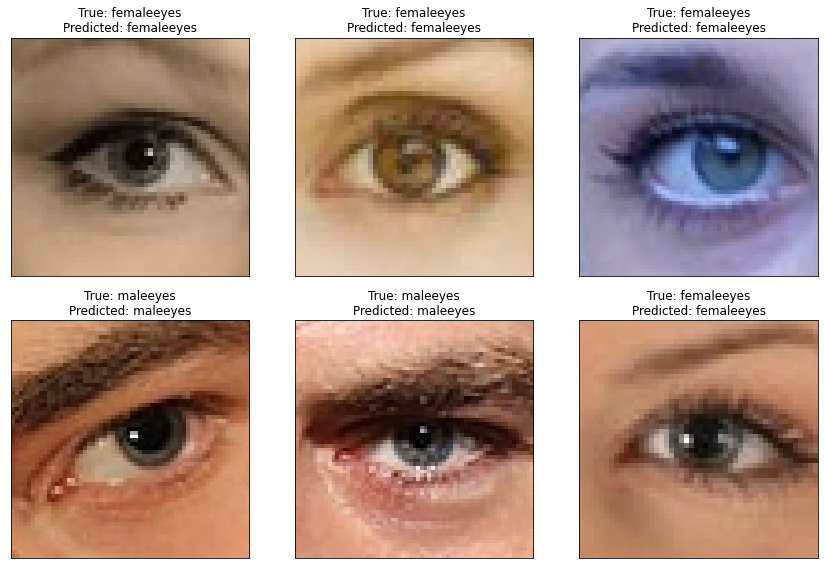

              Results 
    Test Loss:  0.32572  
Test Accuracy:  90.59%  


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
result_MobileNet = func(preprocess_input,MobileNet)

<h2>✔️ InceptionResNetV2</h2>

#####~Model => <function InceptionResNetV2 at 0x7f8fc9e1b170> 
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.
219070464/219055592 [==============================] - 1s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


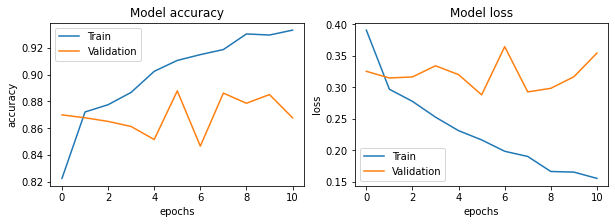

              Classification_report 
              precision    recall  f1-score   support

  femaleeyes       0.81      0.93      0.86      1011
    maleeyes       0.94      0.83      0.88      1294

    accuracy                           0.87      2305
   macro avg       0.87      0.88      0.87      2305
weighted avg       0.88      0.87      0.87      2305

 Display 6 pictures of the dataset with their labels 


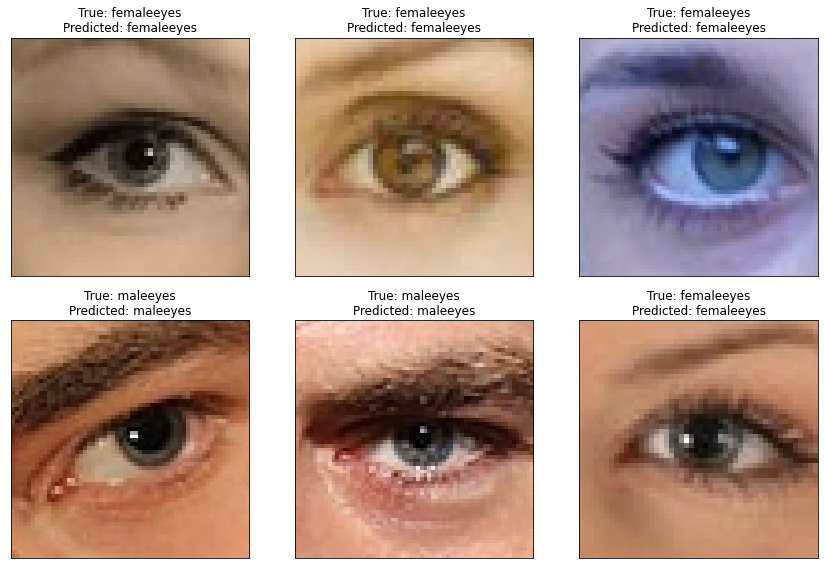

              Results 
    Test Loss:  0.35509  
Test Accuracy:  87.29%  


In [ ]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
result_InResNetV2 = func(preprocess_input,InceptionResNetV2)

<h2>✔️ DenseNet201</h2>

#####~Model => <function DenseNet201 at 0x7f8fc9e174d0> 
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.
74850304/74836368 [==============================] - 1s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


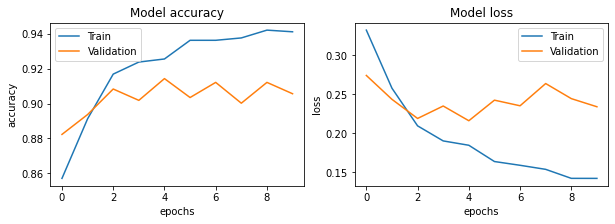

              Classification_report 
              precision    recall  f1-score   support

  femaleeyes       0.86      0.94      0.90      1011
    maleeyes       0.95      0.88      0.92      1294

    accuracy                           0.91      2305
   macro avg       0.91      0.91      0.91      2305
weighted avg       0.91      0.91      0.91      2305

 Display 6 pictures of the dataset with their labels 


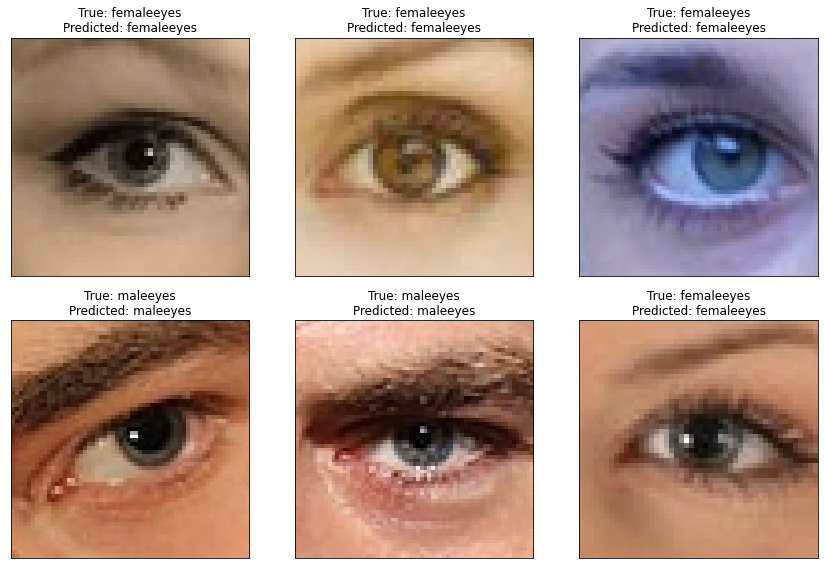

              Results 
    Test Loss:  0.22983  
Test Accuracy:  91.02%  


In [ ]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
result_DenseNet201 = func(preprocess_input,DenseNet201)

<h2>✔️ Xception</h2>

#####~Model => <function Xception at 0x7f8fc9e4cb90> 
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.
83697664/83683744 [==============================] - 0s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


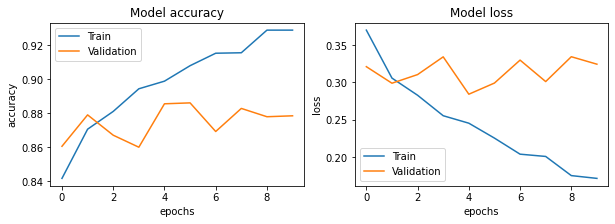

              Classification_report 
              precision    recall  f1-score   support

  femaleeyes       0.85      0.90      0.88      1011
    maleeyes       0.92      0.88      0.90      1294

    accuracy                           0.89      2305
   macro avg       0.88      0.89      0.89      2305
weighted avg       0.89      0.89      0.89      2305

 Display 6 pictures of the dataset with their labels 


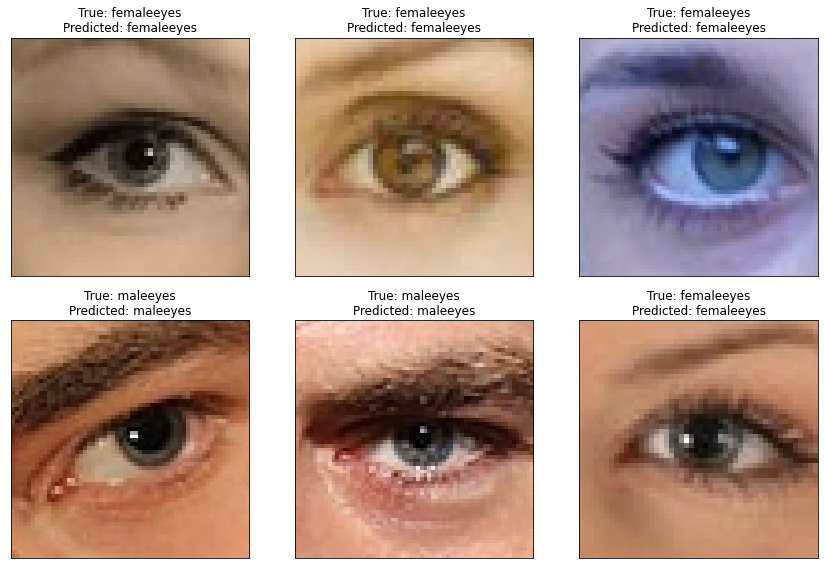

              Results 
    Test Loss:  0.31305  
Test Accuracy:  88.72%  


In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
result_Xception = func(preprocess_input,Xception)

<h2>✔️ EfficientNetB7</h2>

#####~Model => <function EfficientNetB7 at 0x7f8fc9e2a680> 
Found 7376 validated image filenames belonging to 2 classes.
Found 1844 validated image filenames belonging to 2 classes.
Found 2305 validated image filenames belonging to 2 classes.
258088960/258076736 [==============================] - 1s 0us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


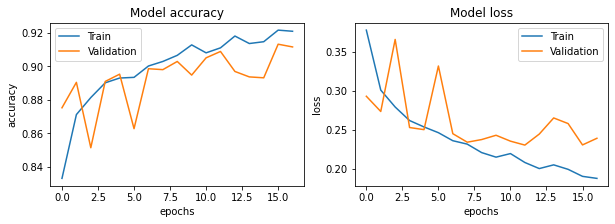

              Classification_report 
              precision    recall  f1-score   support

  femaleeyes       0.92      0.88      0.90      1011
    maleeyes       0.91      0.94      0.92      1294

    accuracy                           0.91      2305
   macro avg       0.91      0.91      0.91      2305
weighted avg       0.91      0.91      0.91      2305

 Display 6 pictures of the dataset with their labels 


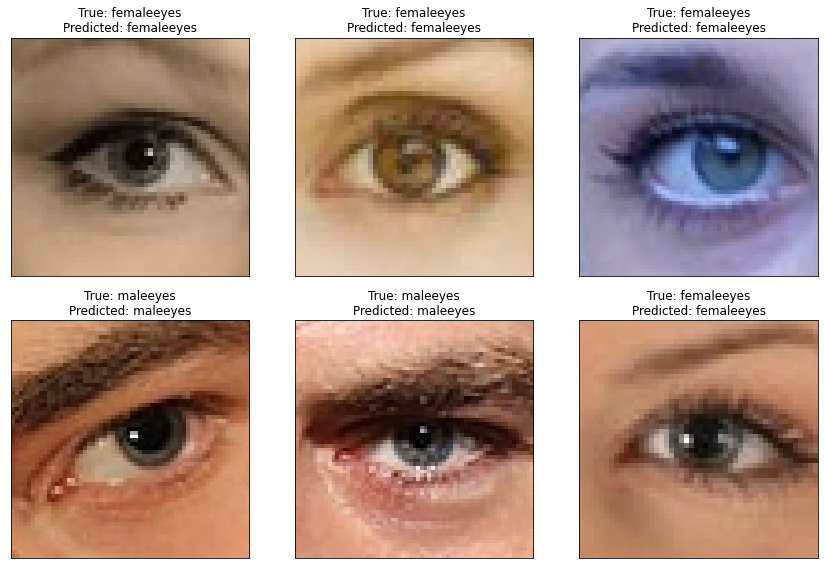

              Results 
    Test Loss:  0.22365  
Test Accuracy:  91.32%  


In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.applications.efficientnet import preprocess_input
result_Eff = func(preprocess_input,EfficientNetB7)

<a id="7"></a> <br>
# 📊 Final Report

In [ ]:
output = pd.DataFrame({'Model':['VGG16','VGG19','ResNet50','ResNet101','MobileNet','InceptionResNetV2',
                               'DenseNet201','Xception','EfficientNetB7'],
                      'Accuracy':[result_VGG16[1], result_VGG19[1], result_ResNet50[1], result_ResNet101[1],
                                  result_MobileNet[1],result_InResNetV2[1],result_DenseNet201[1],result_Xception[1],
                                 result_Eff[1]]})

In [ ]:
output

,Model,Accuracy
0,VGG16,0.883731
1,VGG19,0.876356
2,ResNet50,0.912798
3,ResNet101,0.902820
4,MobileNet,0.905857
5,InceptionResNetV2,0.872885
6,DenseNet201,0.910195
7,Xception,0.887202
8,EfficientNetB7,0.913232


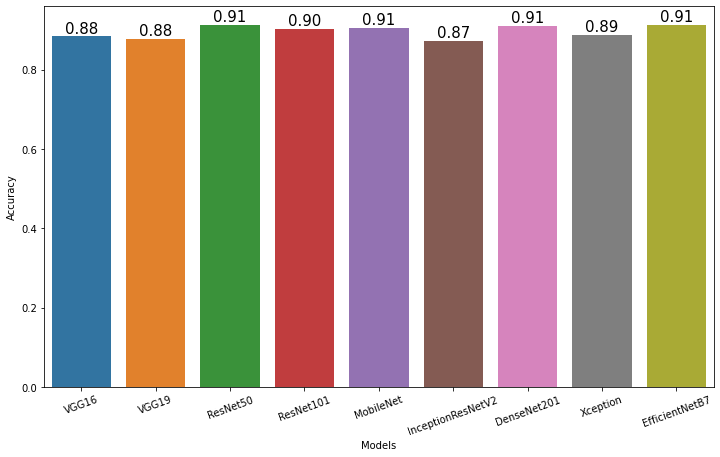

In [ ]:
plt.figure(figsize=(12, 7))
plots = sns.barplot(x='Model', y='Accuracy', data=output)
for bar in plots.patches:
    plots.annotate(format(bar.get_height(), '.2f'),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=15, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.xticks(rotation=20);